<a href="https://colab.research.google.com/github/yasuke123/perium-/blob/main/NYPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
#import pandas - will write downloaded data to data frames
import pandas as pd
#import zipfile for zip file extraction
import zipfile
#import urlretrieve from urllib, wich is packaged with Python and can retrieve files directly from the web
from urllib.request import urlretrieve
import numpy as np


In [95]:
#files from 2003 through 2014 in zip format - csv within each zip with naming convention YYYY.csv

#loop through years
years = ['2012','2013','2014']
counter = 0

for year in years:
    zipurl = 'https://www.nyc.gov/assets/nypd/downloads/zip/analysis_and_planning/stop-question-frisk/sqf-' + year + '-csv.zip'
    csvfile = year + '.csv'

    data = urlretrieve(zipurl)

    #extract zip files - the first element in data is the temp file with the zip contents
    #ref https://gist.github.com/ZeccaLehn/140edc75ff9d2c7cf9f660028763c9f5
    z = zipfile.ZipFile(data[0])
    z.extractall()

    #read extracted csv file into dataframe
    df = pd.read_csv(csvfile,low_memory=False)

    if counter == 0:
        all_data = df
    else:
        all_data = pd.concat([all_data, df], axis=0)

    counter+=1

In [96]:
#files from 2003 through 2014 in zip format - csv within each zip with naming convention YYYY.csv

#loop through years
years = ['2012','2013','2014']
counter = 0

for year in years:
    zipurl = 'https://www.nyc.gov/assets/nypd/downloads/zip/analysis_and_planning/stop-question-frisk/sqf-' + year + '-csv.zip'
    csvfile = year + '.csv'

    data = urlretrieve(zipurl)

    #extract zip files - the first element in data is the temp file with the zip contents
    #ref https://gist.github.com/ZeccaLehn/140edc75ff9d2c7cf9f660028763c9f5
    z = zipfile.ZipFile(data[0])
    z.extractall()

    #read extracted csv file into dataframe
    df = pd.read_csv(csvfile,low_memory=False)

    if counter == 0:
        all_data = df
    else:
        all_data = pd.concat([all_data, df], axis=0)

    counter+=1

In [97]:
# Identify column types
numerical_cols = [ 'pct', 'datestop', 'timestop', 'perobs', 'ht_feet', 'ht_inch', 'weight', 'xcoord', 'ycoord'] #year is removed because its a timeline
binary_cols = ['arstmade', 'sumissue', 'frisked', 'searched', 'pistol', 'riflshot', 'knifcuti']
categorical_cols = ['crimsusp', 'sex', 'race', 'inout', 'trhsloc', 'age']  # Start with key categoricals

In [98]:
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Coerce errors to NaN

# Clean binary columns (map Y/N to 1/0, handle spaces)
for col in binary_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0, ' ': 0}).fillna(0)

In [99]:
# Handle missing values (replace spaces or '*' with NaN)
df.replace(' ', np.nan, inplace=True)
df.replace('*', np.nan, inplace=True)

# Drop rows with too many NaNs for analysis (or impute if needed)
df_clean = df.dropna(subset=numerical_cols + binary_cols)  # Drop rows with NaN in key columns

# Create analysis dataset for numerical and binary columns
analysis_data = df_clean[numerical_cols + binary_cols].copy()


<ipython-input-99-490de86897c1>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(' ', np.nan, inplace=True)


In [100]:
# Verify data
print("Data types after cleaning:")
print(analysis_data.dtypes)
print("\nSample of cleaned data:")
print(analysis_data.head())
print("\nDescriptive statistics:")
print(analysis_data.describe())

# Check categorical columns for unique values
for col in categorical_cols:
    print(f"\nUnique values in {col}: {df_clean[col].unique()}")

Data types after cleaning:
pct           int64
datestop      int64
timestop      int64
perobs      float64
ht_feet       int64
ht_inch       int64
weight        int64
xcoord      float64
ycoord      float64
arstmade      int64
sumissue      int64
frisked       int64
searched      int64
pistol      float64
riflshot    float64
knifcuti    float64
dtype: object

Sample of cleaned data:
   pct  datestop  timestop  perobs  ht_feet  ht_inch  weight     xcoord  \
0   67   1012014      2330     1.0        5        7     150  1000633.0   
1    7   1032014      1530     2.0        5        7     160   987521.0   
2   84   1042014      2100     1.0        5        8     160   988579.0   
3   84   1092014      1250     1.0        5        7     150   988827.0   
4   77   1092014      1310     1.0        5       10     200  1005873.0   

     ycoord  arstmade  sumissue  frisked  searched  pistol  riflshot  knifcuti  
0  176542.0         0         0        1         0     0.0       0.0       0.0  
1

- Drop Identifiers: ser_num is a unique identifier—drop unless tracking individual stops is needed.
- Drop Administrative: recstat, repcmd, revcmd, compyear, comppct are likely internal codes—drop unless administrative analysis is required.
- Drop Redundant Location: addrtyp, premtype, stname, premname, addrnum, aptnum, city, state, zip, sector, beat, post are detailed location data—keep pct, xcoord, ycoord and drop others unless geographic text analysis is key.

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

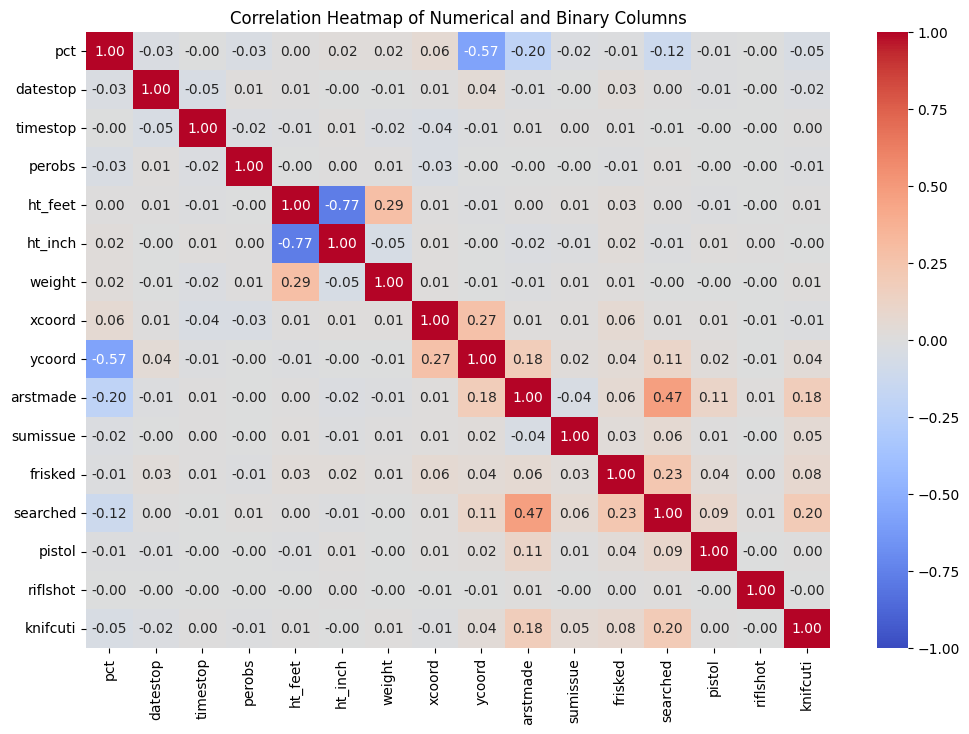

In [102]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = analysis_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Heatmap of Numerical and Binary Columns')
plt.show()

In [103]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [104]:
print(analysis_data.dtypes)

pct           int64
datestop      int64
timestop      int64
perobs      float64
ht_feet       int64
ht_inch       int64
weight        int64
xcoord      float64
ycoord      float64
arstmade      int64
sumissue      int64
frisked       int64
searched      int64
pistol      float64
riflshot    float64
knifcuti    float64
dtype: object


In [105]:
analysis_data.columns

Index(['pct', 'datestop', 'timestop', 'perobs', 'ht_feet', 'ht_inch', 'weight',
       'xcoord', 'ycoord', 'arstmade', 'sumissue', 'frisked', 'searched',
       'pistol', 'riflshot', 'knifcuti'],
      dtype='object')

In [106]:
vif_data = pd.DataFrame()
vif_data['Feature'] = analysis_data[numerical_cols].columns
vif_data['VIF'] = [variance_inflation_factor(analysis_data[numerical_cols].values, i)
                   for i in range(analysis_data[numerical_cols].shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)
print("\nVIF Results (Sorted by VIF):")
print(vif_data)


VIF Results (Sorted by VIF):
    Feature         VIF
7    xcoord  518.394991
4   ht_feet  346.145315
8    ycoord   80.333294
6    weight   27.146197
0       pct    9.532710
5   ht_inch    9.430270
1  datestop    4.283531
2  timestop    4.187343
3    perobs    1.181307



VIF Results (Sorted by VIF):
    Feature         VIF
7    xcoord  518.394991
4   ht_feet  346.145315
8    ycoord   80.333294
6    weight   27.146197
0       pct    9.532710
5   ht_inch    9.430270
1  datestop    4.283531
2  timestop    4.187343
3    perobs    1.181307


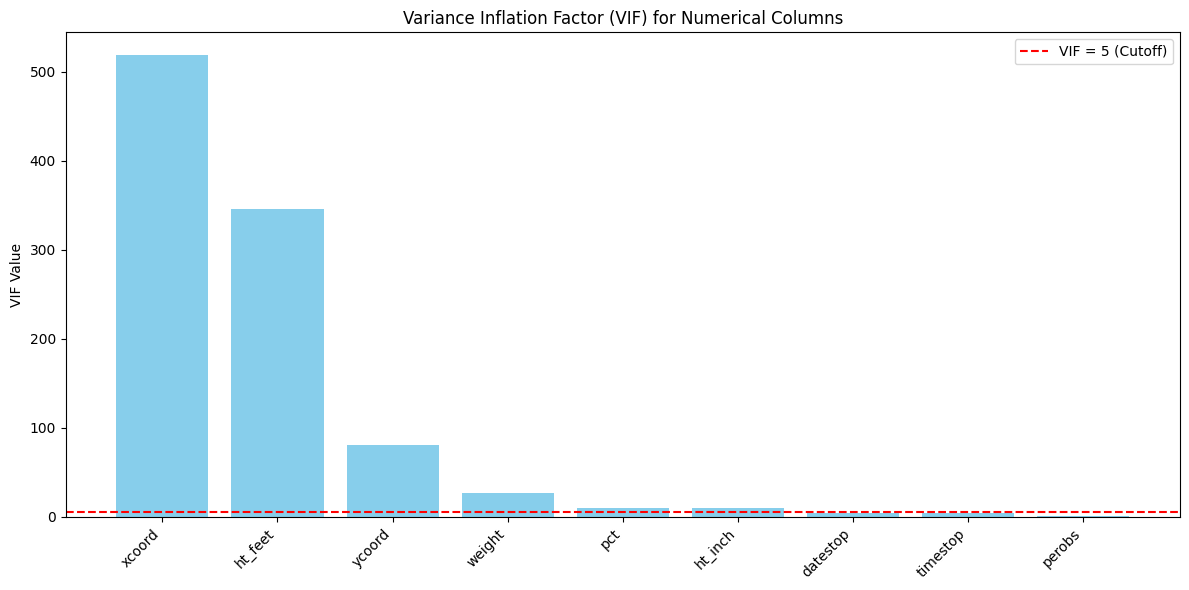

In [107]:

# VIF Analysis (numerical only)
vif_data = pd.DataFrame()
vif_data['Feature'] = analysis_data[numerical_cols].columns

vif_data['VIF'] = [variance_inflation_factor(analysis_data[numerical_cols].values, i)
                   for i in range(analysis_data[numerical_cols].shape[1])]

# Sort and print VIF
vif_data = vif_data.sort_values('VIF', ascending=False)
print("\nVIF Results (Sorted by VIF):")
print(vif_data)

# Graph VIF with cutoff
plt.figure(figsize=(12, 6))
bars = plt.bar(vif_data['Feature'], vif_data['VIF'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Variance Inflation Factor (VIF) for Numerical Columns')
plt.ylabel('VIF Value')
plt.axhline(y=5, color='red', linestyle='--', label='VIF = 5 (Cutoff)')
plt.legend()
plt.tight_layout()
plt.show()

-Combine ht_feet and ht_inch into height_in_inches:

-Drop ht_feet and ht_inch.

-Add height_in_inches to numerical_cols.

-Keep xcoord and ycoord for spatial analysis, despite high VIF, unless spatial precision isn’t needed.

-Keep pct, datestop, timestop, perobs, weight (pending weight verification).